In [1]:
import time
from contextlib import contextmanager
from functools import partial
from itertools import chain
from itertools import repeat
from typing import Generator
from typing import Sequence

import graphviz
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchview import draw_graph
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [2]:
BATCH_SIZE = 300
LR = 0.01
EPOCHS = 30
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

torch.manual_seed(42);

In [3]:
def one_hot(class_: int) -> torch.Tensor:
    vec = torch.zeros(10, dtype=torch.float32)
    vec[class_] = 1.0

    return vec

In [4]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4, padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


dataset = partial(CIFAR10, root="./data", download=True)
train_dataset = dataset(train=True, transform=transform_train, target_transform=one_hot)
test_dataset = dataset(train=False, transform=transform_test, target_transform=one_hot)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Files already downloaded and verified
Files already downloaded and verified


In [5]:

def show_images(dataset: CIFAR10, title: str, nx: int = 9, ny: int = 2):
    fig, axes = plt.subplots(
        ny,
        nx,
        figsize=(nx*1.5, ny*1.5 + 0.5),
        sharex=True,
        sharey=True,
        tight_layout=True,
    )

    fig.suptitle(title)

    input_shape = (32, 32, 3)

    for ax, image, label in zip(axes.flat, dataset.data, dataset.targets):
        if image.shape != input_shape:
            raise ValueError("Wrong input shape!")

        ax.imshow(image, label=label)
        ax.set_axis_off()
        ax.text(0, 0, train_dataset.classes[label], color="lime", backgroundcolor="black")
    else:
        print(f"All image shapes are valid ({input_shape})")

All image shapes are valid ((32, 32, 3))
All image shapes are valid ((32, 32, 3))


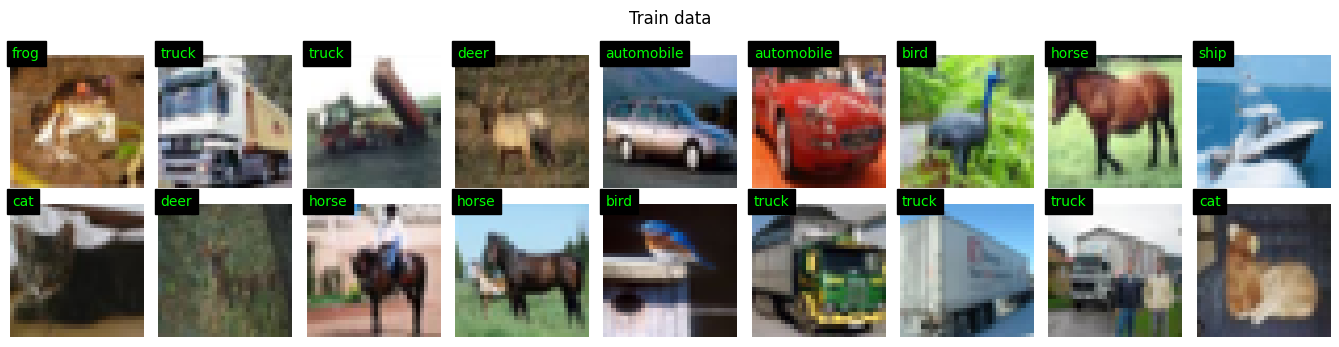

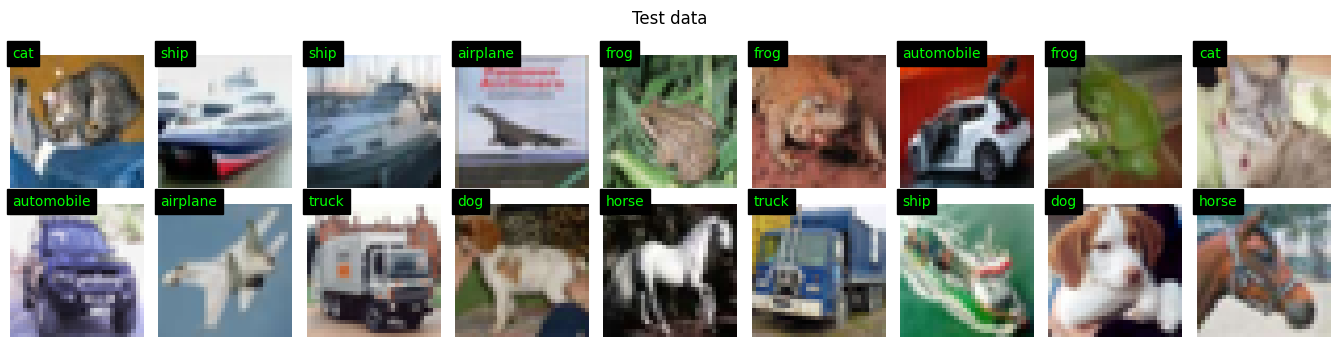

In [6]:
show_images(train_dataset, "Train data")
show_images(test_dataset, "Test data")

In [7]:
class BasicBlock(nn.Module):
    _expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self._expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self._expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self._expansion*planes),
            )

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(data)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(data)
        out = F.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, blocks_config: Sequence[int], *, num_classes: int = 10) -> None:
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        layers: list[nn.Module] = []
        for out_features, num_blocks, stride in zip(
            [64, 128, 256, 512],
            blocks_config,
            [1, 2, 2, 2],
        ):
            layers.append(self._make_layer(out_features, num_blocks, stride))

        self.layers = nn.Sequential(*layers)
        self.linear = nn.Linear(512*BasicBlock._expansion, num_classes)

    def _make_layer(self, planes: int, num_blocks, stride):
        strides = chain([stride], repeat(1, num_blocks - 1))
        layers: list[nn.Module] = []

        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock._expansion

        return nn.Sequential(*layers)

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(data)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 4)
        out = out.squeeze(dim=(2, 3))
        out = self.linear(out)

        return out


In [8]:
@contextmanager
def timeit(message: str = "Time passed: {:2.03f}") -> Generator[None, None, None]:
    start = time.monotonic()

    try:
        yield
    finally:
        print(message.format(time.monotonic() - start))

In [9]:
def get_correct_num(predictions, ground_truth) -> int:
    with torch.no_grad():
        correct = (
            (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
            .cpu()
            .detach()
            .to(torch.int32)
            .sum()
            .item()
        )

    return correct

In [10]:
model = ResNet([2, 2, 2, 2], num_classes=10)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

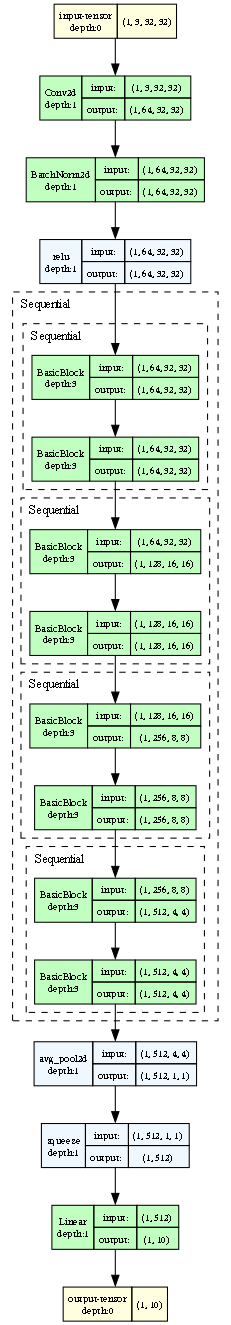

In [11]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph

In [12]:
loss = torch.nn.CrossEntropyLoss(reduction='mean')

model = ResNet([2, 2, 2, 2], num_classes=10)
model.to(DEVICE)
model.train()

optimizer = torch.optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    [15, 25],
    gamma=0.1,
)

with timeit('Finish training in: {:.04f}s'):
    for epoch_no in range(1, EPOCHS + 1):
        running_loss = 0
        correct = 0
        train_mean_loss = 0

        for signals, ground_truth in tqdm(
            train_dataloader,
            desc='Train batches',
            total=len(train_dataloader),
        ):
            optimizer.zero_grad()

            signals = signals.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(signals)
            loss_value = loss(predictions, ground_truth)
            loss_value.backward()

            optimizer.step()

            correct += get_correct_num(predictions, ground_truth)
            mean_loss = torch.mean(loss_value.cpu().detach()).item()
            running_loss += mean_loss

            train_mean_loss = running_loss / len(train_dataloader)

        scheduler.step()

        accuracy = correct / len(train_dataloader.dataset)

        print(
            f'Epoch: {epoch_no:02d} '
            f'| train loss: {train_mean_loss:.4f} '
            f'| accuracy: {accuracy:.4f}\n'
        )


Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.37it/s]


Epoch: 01 | train loss: 1.9065 | accuracy: 0.3021



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.34it/s]


Epoch: 02 | train loss: 1.4237 | accuracy: 0.4798



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.37it/s]


Epoch: 03 | train loss: 1.1400 | accuracy: 0.5897



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.28it/s]


Epoch: 04 | train loss: 0.9450 | accuracy: 0.6655



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.33it/s]


Epoch: 05 | train loss: 0.8146 | accuracy: 0.7127



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.29it/s]


Epoch: 06 | train loss: 0.7129 | accuracy: 0.7509



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.35it/s]


Epoch: 07 | train loss: 0.6171 | accuracy: 0.7849



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.32it/s]


Epoch: 08 | train loss: 0.5409 | accuracy: 0.8136



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.34it/s]


Epoch: 09 | train loss: 0.4822 | accuracy: 0.8336



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.32it/s]


Epoch: 10 | train loss: 0.4434 | accuracy: 0.8465



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.34it/s]


Epoch: 11 | train loss: 0.3972 | accuracy: 0.8611



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.35it/s]


Epoch: 12 | train loss: 0.3657 | accuracy: 0.8703



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.35it/s]


Epoch: 13 | train loss: 0.3351 | accuracy: 0.8835



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.34it/s]


Epoch: 14 | train loss: 0.3075 | accuracy: 0.8924



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.31it/s]


Epoch: 15 | train loss: 0.2914 | accuracy: 0.8974



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.38it/s]


Epoch: 16 | train loss: 0.1976 | accuracy: 0.9319



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.32it/s]


Epoch: 17 | train loss: 0.1627 | accuracy: 0.9436



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.38it/s]


Epoch: 18 | train loss: 0.1515 | accuracy: 0.9471



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.30it/s]


Epoch: 19 | train loss: 0.1396 | accuracy: 0.9513



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.36it/s]


Epoch: 20 | train loss: 0.1318 | accuracy: 0.9544



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.29it/s]


Epoch: 21 | train loss: 0.1229 | accuracy: 0.9570



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.37it/s]


Epoch: 22 | train loss: 0.1138 | accuracy: 0.9604



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.28it/s]


Epoch: 23 | train loss: 0.1072 | accuracy: 0.9623



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.35it/s]


Epoch: 24 | train loss: 0.1004 | accuracy: 0.9658



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.28it/s]


Epoch: 25 | train loss: 0.0924 | accuracy: 0.9681



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.36it/s]


Epoch: 26 | train loss: 0.0810 | accuracy: 0.9718



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.29it/s]


Epoch: 27 | train loss: 0.0747 | accuracy: 0.9742



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.37it/s]


Epoch: 28 | train loss: 0.0729 | accuracy: 0.9747



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.28it/s]


Epoch: 29 | train loss: 0.0703 | accuracy: 0.9766



Train batches: 100%|██████████| 167/167 [00:31<00:00,  5.33it/s]

Epoch: 30 | train loss: 0.0705 | accuracy: 0.9759

Finish training in: 939.8750s


In [13]:
model.eval()
correct = 0

with timeit('Finish testing in {:.4f}s'):
    with torch.no_grad():
        for data, ground_truth in test_dataloader:
            data = data.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            predictions = model(data)

            correct += get_correct_num(predictions, ground_truth)

print(f"Accuracy: {correct / len(test_dataloader.dataset):.4f}")

Finish testing in 2.2350s
Accuracy: 0.9102


In [14]:
model_path = 'resnet.pth'
torch.save(model.state_dict(), model_path)

In [15]:
model = ResNet([2, 2, 2, 2], num_classes=10)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>